Test/ Train a model.

In [26]:
from myelin_dataset import MyelinDataset
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [39]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")  # Force CPU for debugging
print("Using device:", device)

Using device: cpu


In [53]:

# ------------------------------
# Load data
# ------------------------------
with open("train_data.pkl", "rb") as f:
    train_df = pickle.load(f)

with open("test_data.pkl", "rb") as f:
    test_df = pickle.load(f)

train_dataset = MyelinDataset(train_df)
test_dataset = MyelinDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ------------------------------
# Model definition
# ------------------------------
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 40 * 100, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # No Sigmoid here
        )

    def forward(self, x):
        return self.net(x)

model = SimpleClassifier().to(device)

#If loading model:
model.load_state_dict(torch.load("myelin_classifier_v0.pt"))




<All keys matched successfully>

In [78]:
model = model.to(device)  # Move model to device
# ------------------------------
# Loss function with class weights
# ------------------------------
pos_weight = torch.tensor([8655 / 2248]).to(device)  # class imbalance ratio
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ------------------------------
# Optimizer
# ------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# ------------------------------
# Training loop
# ------------------------------
for epoch in range(2000):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.float().unsqueeze(1).to(device)  # [B] -> [B,1]

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")

# ------------------------------
# Evaluation
# ------------------------------
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.float().to(device)

        logits = model(images)
        probs = torch.sigmoid(logits).squeeze()  # [B, 1] -> [B]
        preds = (probs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Epoch 1 | Train Loss: 0.0014
Epoch 2 | Train Loss: 0.0011
Epoch 3 | Train Loss: 0.0011
Epoch 4 | Train Loss: 0.0012
Epoch 5 | Train Loss: 0.0018
Epoch 6 | Train Loss: 0.0010
Epoch 7 | Train Loss: 0.0012
Epoch 8 | Train Loss: 0.0012
Epoch 9 | Train Loss: 0.0010
Epoch 10 | Train Loss: 0.0014
Epoch 11 | Train Loss: 0.0011
Epoch 12 | Train Loss: 0.0011
Epoch 13 | Train Loss: 0.0010
Epoch 14 | Train Loss: 0.0012
Epoch 15 | Train Loss: 0.0010
Epoch 16 | Train Loss: 0.0019
Epoch 17 | Train Loss: 0.0011
Epoch 18 | Train Loss: 0.0010
Epoch 19 | Train Loss: 0.0011
Epoch 20 | Train Loss: 0.0011
Epoch 21 | Train Loss: 0.0012
Epoch 22 | Train Loss: 0.0013
Epoch 23 | Train Loss: 0.0016
Epoch 24 | Train Loss: 0.0011
Epoch 25 | Train Loss: 0.0011
Epoch 26 | Train Loss: 0.0011
Epoch 27 | Train Loss: 0.0012
Epoch 28 | Train Loss: 0.0012
Epoch 29 | Train Loss: 0.0012
Epoch 30 | Train Loss: 0.0011
Epoch 31 | Train Loss: 0.0015
Epoch 32 | Train Loss: 0.0012
Epoch 33 | Train Loss: 0.0010
Epoch 34 | Train Lo

In [80]:
print("Mean prob:", probs.mean().item())

Mean prob: 0.23687531054019928


Showing mistakes 50 to 100 (total mistakes: 59)


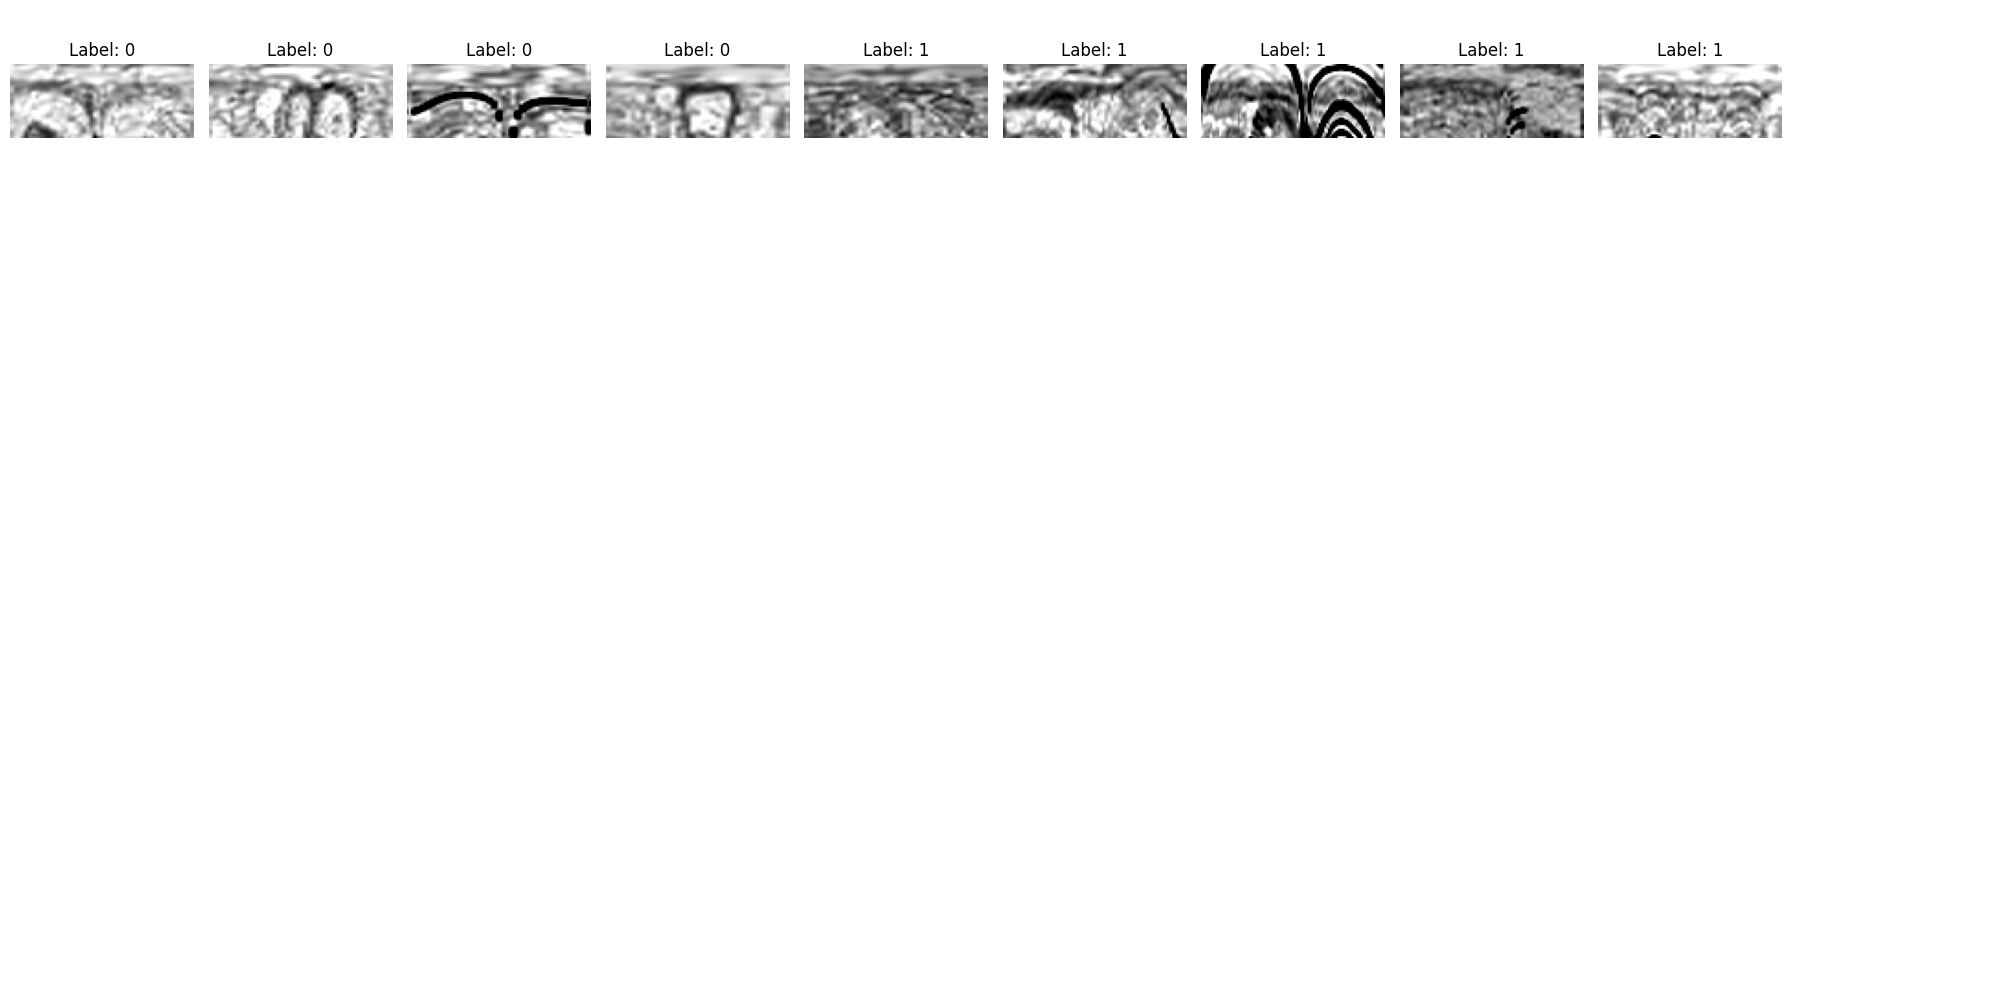

In [81]:
def show_misclassified_examples(model, dataset, batch_size=32, rows=5, cols=10, page=0):
    """
    Displays misclassified images in a grid.

    Parameters:
        model: Trained PyTorch model
        dataset: Dataset to evaluate (e.g., test_dataset)
        batch_size: Batch size for DataLoader
        rows: Rows in subplot grid
        cols: Columns in subplot grid
        page: Which "page" of results to show (0 = first 50, 1 = next 50, etc.)
    """
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    mistakes = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.float()
            labels = labels.float().unsqueeze(1)

            logits = model(images)
            probs = torch.sigmoid(logits).squeeze()
            preds = (probs > 0.5).float()

            # Find mismatches
            mismatches = (preds != labels.squeeze()).nonzero(as_tuple=True)[0]
            for idx in mismatches:
                img = images[idx].squeeze().cpu().numpy()  # shape: 40x100
                true_label = int(labels[idx].item())
                mistakes.append((img, true_label))

    # Show selected batch
    start = page * (rows * cols)
    end = start + (rows * cols)
    selected = mistakes[start:end]

    print(f"Showing mistakes {start} to {end} (total mistakes: {len(mistakes)})")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(selected):
            img, label = selected[i]
            ax.imshow(img, cmap='gray',vmin=110, vmax=145)
            ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_misclassified_examples(model, test_dataset, rows=5, cols=10, page=1)

In [ ]:
#save model params:
torch.save(model.state_dict(), "myelin_classifier_v0_2.pt")

SimpleClassifier(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4000, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)
